In [1]:
from utils.utils import train_model, base_transform, evaluate_model_with_cm, TiffDataset
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
import numpy as np
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import copy
import torch.nn.functional as F
from  models.video_classifier import VideoClassifier
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class ResNetClassifier(nn.Module):
    def __init__(self, in_channels, num_classes=6, kernel_size=3):
        super(ResNetClassifier, self).__init__()
        # ResNet18 모델을 기반으로 사용
        self.transform = transform
        self.resnet = models.resnet18(weights=None)  # 사전 훈련 없이 초기화
        self.resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=kernel_size, stride=1, padding=1, bias=False)  # 입력 채널 9개로 변경
        self.resnet.maxpool = nn.Identity()  # 5x5 입력이므로 MaxPooling 제거
        self.resnet.fc = nn.Linear(512, num_classes)  # 마지막 출력 뉴런을 클래스 수에 맞게 변경

    def forward(self, x):
        return self.resnet(x)

In [4]:
class FeedForwardBlock(nn.Module):
    def __init__(self, dim, expand_ratio=4, dropout=0.1):
        super(FeedForwardBlock, self).__init__()
        hidden_dim = dim * expand_ratio
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, dim)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, dim, expand_ratio=4, dropout=0.1):
        super(ResidualBlock, self).__init__()
        self.norm = nn.LayerNorm(dim)
        self.ffn = FeedForwardBlock(dim, expand_ratio, dropout)
    
    def forward(self, x):
        out = self.norm(x)
        out = self.ffn(out)
        return x + out  # Skip Connection

class DNNClassifier(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=128, output_dim=6, num_layers=10, expand_ratio=4, dropout=0.1):
        super(DNNClassifier, self).__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.layers = nn.Sequential(*[ResidualBlock(hidden_dim, expand_ratio, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.layers(x)
        x = self.output_layer(x)
        return x


In [5]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=10, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=12, dropout=0.1):
        super(TransformerClassifier, self).__init__()

        # Linear layer for embedding input_dim -> embed_dim
        self.input_fc = nn.Linear(input_dim, embed_dim)
        
        # Transformer Encoder Layer 설정 (batch_first=True)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,  # 입력의 임베딩 차원
            nhead=num_heads,  # Multi-head Attention의 head 개수
            dropout=dropout,
            batch_first=True  # 배치 차원이 첫 번째로 오도록 설정
        )
        
        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layer, num_layers=num_layers  # Encoder Layer의 수
        )
        
        # 마지막 출력에서 분류를 위한 Linear Layer
        self.fc = nn.Linear(embed_dim, num_classes)
        
        #가중치 초기화
        self._init_weights()
        
    def forward(self, x):
        # 입력을 임베딩 차원으로 변환
        x = self.input_fc(x)
        
        # Transformer Encoder 통과
        transformer_out = self.transformer_encoder(x)
        
        # transformer_out의 마지막 시퀀스에 해당하는 출력을 가져옵니다.
        # (batch, seq_len, embed_dim) -> (batch, embed_dim)
        out = transformer_out[:, -1, :]
        
        # FC Layer를 통한 분류
        out = self.fc(out)
        
        return out
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.TransformerEncoderLayer):
                nn.init.xavier_uniform_(m.linear1.weight)
                nn.init.xavier_uniform_(m.linear2.weight)
                if m.linear1.bias is not None:
                    nn.init.zeros_(m.linear1.bias)
                if m.linear2.bias is not None:
                    nn.init.zeros_(m.linear2.bias)


In [6]:
import torch
import torch.nn.functional as F
import math

def get_gaussian_kernel(kernel_size, sigma):
    """
    2D Gaussian Kernel 생성
    """
    ax = torch.arange(kernel_size, dtype=torch.float32) - (kernel_size - 1) / 2
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()
    return kernel

class DownsampleWithGaussian:
    def __init__(self, kernel_size: int, sigma: float = None):
        """
        kernel_size: 가우시안 필터 크기
        sigma: 가우시안 필터의 표준편차 (None일 경우 기본값 자동 설정)
        """
        self.kernel_size = kernel_size
        if sigma is None:
            sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8  # 일반적인 디폴트 값
        self.sigma = sigma
        
        # 가우시안 커널 생성
        kernel = get_gaussian_kernel(kernel_size, sigma)
        self.kernel = kernel.view(1, 1, kernel_size, kernel_size)  # (1, 1, K, K)
    
    def __call__(self, x):
        """
        x: Tensor of shape (B, T, H, W)
        Returns: Downsampled Tensor of shape (B, T, H//kernel_size, W//kernel_size)
        """
        B, T, H, W = x.shape
  
        if H % self.kernel_size != 0 or W % self.kernel_size != 0:
            raise ValueError(f"Input size ({H}, {W}) must be divisible by kernel_size {self.kernel_size}")
        
        # 채널 차원 추가 후 Gaussian Blur 적용
        x = x.contiguous().view(B * T, 1, H, W)  # (B*T, 1, H, W)
        x_blurred = F.conv2d(x, self.kernel.to(x.device), stride=self.kernel_size, padding=0)  # (B*T, 1, H//K, W//K)
        
        return x_blurred.view(B, T, H // self.kernel_size, W // self.kernel_size)



In [7]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, scheduler=None):
        
    train_losses = []
    val_losses = []
    best_val_f1_score = 0
    best_model_state = model.state_dict()  # 초기 모델 가중치 저장
    no_improve_count = 0

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        train_running_loss = 0.0
        
        train_labels = []
        train_predictions = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item() * labels.size(0)  # 배치별 loss * 개수로 전체 손실 계산
            _, predicted = torch.max(outputs, 1)
            
            train_labels.extend(labels.cpu().numpy())
            train_predictions.extend(predicted.cpu().numpy())
            
        train_loss = train_running_loss / len(train_loader.dataset)  # 전체 샘플 수로 나눔
        train_losses.append(train_loss)
        
        full_class_labels = np.arange(outputs.shape[1])
        train_report = classification_report(train_labels, train_predictions, labels=full_class_labels, output_dict=True)
        
        print(f"\nEpoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_report['accuracy']:.2f}, Train f1-score: {train_report["macro avg"]["f1-score"]:.2f} ")       
    
    return best_model_state, train_losses, val_losses

In [8]:
num_epochs = 50
patience=None
bands = 10
patch_size = 9
time_idx = 4 #5월초
large_tif_dir = '../../data/source_data/with_s2' #원천데이터 주소

In [9]:
kernel_size = 9

공간 모델 사용

In [10]:
transform = transforms.Compose([
    base_transform(bands, patch_size),
    transforms.Lambda(lambda x: x[:,time_idx])
])

train_dataset = TiffDataset(
            large_tif_dir = large_tif_dir,
            file_list = ["jiri_1.tif", "jiri_2.tif", "sobaek.tif"], #전체 지역을 모두 사용한다.
            label_file = "../../data/label_data/species/label_mapping_concated.csv",
            box_filter_fn = lambda box_number: True,
            patch_size = patch_size,
            transform=transform
        )


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [11]:
model_spatial = ResNetClassifier(in_channels=10).to(device)
model_spatial.load_state_dict(torch.load(f"./checkpoints/spectral_spatial/resnet_{bands}_{patch_size}_{kernel_size}_{num_epochs}.pth"))
# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# 🔹 Optimizer (AdamW with weight decay)
optimizer = optim.AdamW(model_spatial.parameters(), lr=1e-3, weight_decay=1e-4)

# # 🔹 Learning Rate Scheduler (StepLR: 10 epochs마다 lr 0.1배 감소)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Epoch 1/1 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7543/7543 [03:03<00:00, 41.09it/s]



Epoch [1/1], Train Loss: 0.1721, Train Accuracy: 0.94, Train f1-score: 0.94 


Evaluation Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7543/7543 [01:26<00:00, 87.50it/s]


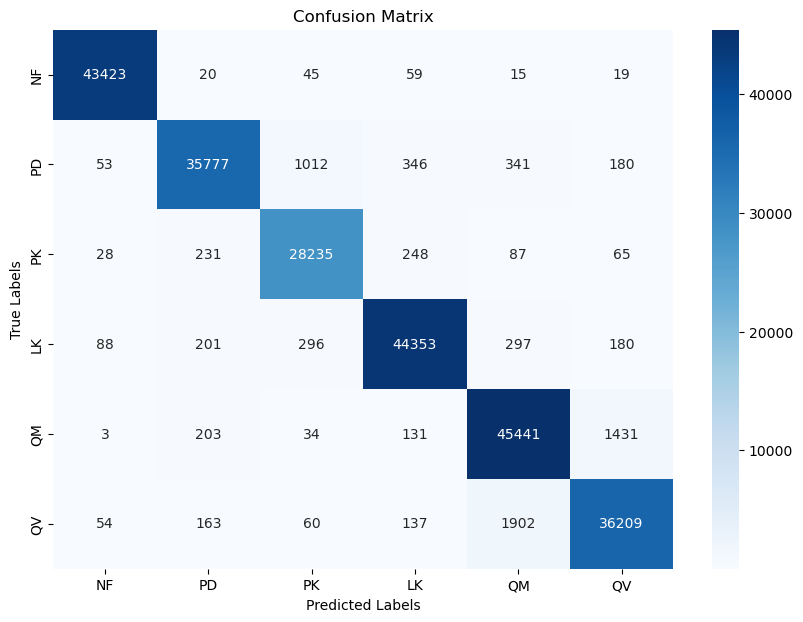

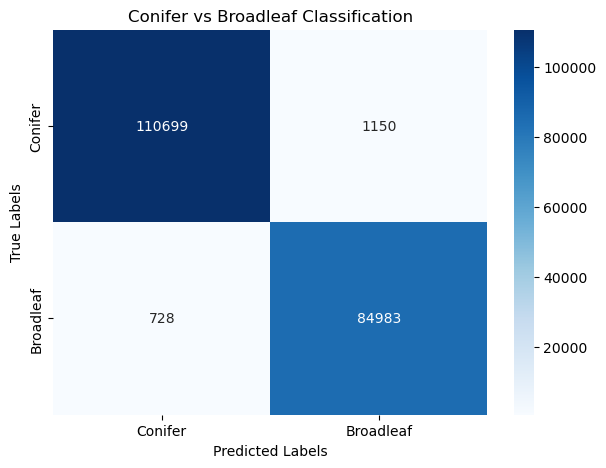

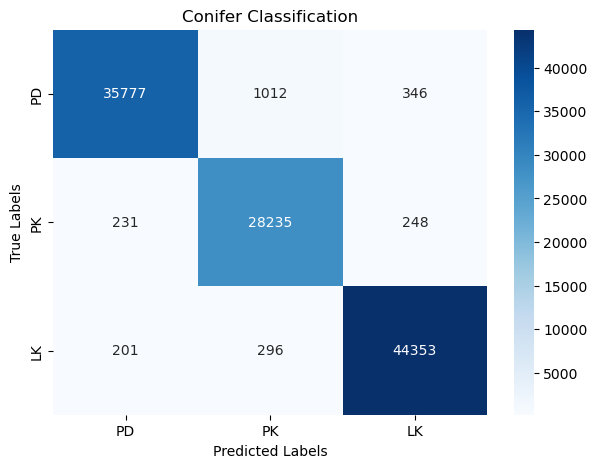

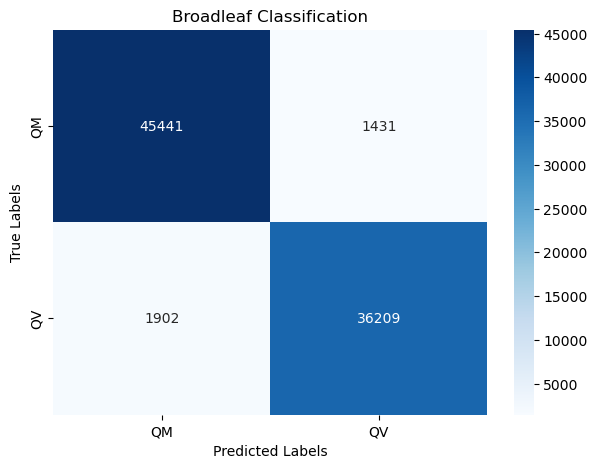

,precision,recall,f1-score,support,task
NF,0.994822,0.996375,0.995598,43581.000000,Overall
PD,0.977647,0.948766,0.962990,37709.000000,Overall
PK,0.951250,0.977192,0.964047,28894.000000,Overall
LK,0.979657,0.976616,0.978134,45415.000000,Overall
QM,0.945053,0.961857,0.953381,47243.000000,Overall
QV,0.950767,0.939883,0.945294,38525.000000,Overall
accuracy,0.967150,0.967150,0.967150,0.967150,Overall
macro avg,0.966533,0.966781,0.966574,241367.000000,Overall
weighted avg,0.967296,0.967150,0.967148,241367.000000,Overall
Conifer,0.993467,0.989718,0.991589,111849.000000,Conifer vs Broadleaf


In [12]:
best_model_state, train_losses, val_losses = train_model(model_spatial, train_loader, criterion, optimizer, 1)
# torch.save(best_model_state, os.path.join(checkpoints_dir, f"resnet_{bands}_{patch_size}_{kernel_size}_{num_epochs}.pth"))
model_spatial.load_state_dict(best_model_state)

evaluate_model_with_cm(model_spatial, train_loader, num_classes=6)

In [14]:
import torch
import pandas as pd

def get_misclassified_dataframe(model, dataloader, dataset, device):
    """
    모델이 틀린 데이터만 원래 데이터프레임 형식으로 반환하는 함수.

    Args:
        model (torch.nn.Module): 학습된 모델
        dataloader (torch.utils.data.DataLoader): 평가용 데이터로더
        dataset (TiffDataset): 사용한 데이터셋 객체 (원본 DataFrame 유지 목적)
        device (str): 'cuda' 또는 'cpu'

    Returns:
        pd.DataFrame: 원본 데이터프레임에서 모델이 오분류한 샘플들만 포함한 데이터프레임
    """
    model.eval()
    misclassified_indices = []

    with torch.no_grad():
        for batch_idx, (patches, labels) in enumerate(dataloader):
            patches, labels = patches.to(device), labels.to(device)
            batch_start = batch_idx * dataloader.batch_size  # 배치의 시작 인덱스

            outputs = model(patches)
            predictions = torch.argmax(outputs, dim=1)

            incorrect_mask = predictions != labels
            incorrect_batch_indices = incorrect_mask.nonzero(as_tuple=True)[0].tolist()

            # 전체 데이터셋에서 실제 인덱스 변환
            for i in incorrect_batch_indices:
                global_index = batch_start + i  # 전체 dataset의 인덱스로 변환
                if global_index < len(dataset):  # 안전 확인
                    misclassified_indices.append(dataset.valid_indices[global_index])

    # 오분류된 데이터만 원래 데이터프레임에서 추출
    misclassified_df = dataset.label_df.iloc[misclassified_indices].copy()

    return misclassified_df


In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# 오분류 데이터 가져오기 (원본 데이터프레임 형태 유지)
misclassified_df = get_misclassified_dataframe(model_spatial, train_loader, train_dataset, device)

# # 결과 확인
# print(misclassified_df.head())

# # CSV로 저장 (필요하면)
# misclassified_df.to_csv("misclbassified_samples.csv", index=False)


In [19]:
df = pd.read_csv("../../data/label_data/species/label_mapping_concated.csv")
df

,label,x_pos,y_pos,file,box_number,tree_species,type
0,4,1060,1063,jiri_1.tif,23,QM,train
1,4,463,997,jiri_1.tif,22,QM,train
2,4,889,1147,jiri_1.tif,33,QM,train
3,4,652,298,jiri_1.tif,2,QM,train
4,4,388,634,jiri_1.tif,12,QM,train
...,...,...,...,...,...,...,...
242495,5,1078,568,sobaek.tif,13,QV,test
242496,5,1126,505,sobaek.tif,14,QV,test
242497,5,190,430,sobaek.tif,11,QV,test
242498,5,3535,751,sobaek.tif,30,QV,test


In [22]:
spatial_df = misclassified_df

In [ ]:
# ✅ 메모리 정리
del model
torch.cuda.empty_cache()

시간 정보 사용

In [24]:
def reshape_transform(x):
    x = x.squeeze(-1).squeeze(-1)  # (10, 12, 1, 1) → (10, 12)
    x = x.permute(1, 0)  # (10, 12) → (12, 10)
    return x

transform = transforms.Compose([
    base_transform(bands, patch_size),
    DownsampleWithGaussian(kernel_size, sigma=3),
    transforms.Lambda(reshape_transform)
])

train_dataset.transform = transform

In [27]:
model_temporal =  TransformerClassifier(input_dim=10, embed_dim=16, num_heads=2, num_layers=2, num_classes=6, seq_len=12).to(device)
model_temporal.load_state_dict(torch.load(os.path.join(f"./checkpoints/spectral_temporal/transformer_{bands}_{patch_size}_{num_epochs}.pth")))
# 🔹 Loss function (Categorical Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer 설정
optimizer = optim.AdamW(model_temporal.parameters(), lr=3e-4, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [28]:
best_model_state, train_losses, val_losses = train_model(model_temporal, train_loader, criterion, optimizer, 1)

model_temporal.load_state_dict(best_model_state)

evaluate_model_with_cm(model_temporal, train_loader, num_classes=6)

Epoch 1/1 - Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7543/7543 [02:31<00:00, 49.82it/s]



Epoch [1/1], Train Loss: 0.3834, Train Accuracy: 0.92, Train f1-score: 0.92 


Evaluation Progress:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 5414/7543 [01:19<00:31, 67.78it/s]


KeyboardInterrupt: 

In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# 오분류 데이터 가져오기 (원본 데이터프레임 형태 유지)
tempral_df = get_misclassified_dataframe(model_temporal, train_loader, train_dataset, device)

In [31]:
common_df = pd.merge(spatial_df, tempral_df, how="inner")

In [33]:
common_df

,label,x_pos,y_pos,file,box_number,tree_species,type
0,4,343,247,jiri_1.tif,1,QM,train
1,4,334,490,jiri_1.tif,11,QM,train
2,4,454,1912,jiri_1.tif,52,QM,train
3,4,925,2746,jiri_1.tif,73,QM,train
4,4,3193,1393,jiri_1.tif,39,QM,train
...,...,...,...,...,...,...,...
5608,4,472,2791,sobaek.tif,72,QM,test
5609,4,220,2218,sobaek.tif,61,QM,test
5610,4,1081,1477,sobaek.tif,44,QM,test
5611,4,1951,1414,sobaek.tif,36,QM,test


In [32]:
len(common_df) * 100 / len(spatial_df)

70.790768066591

In [34]:
common_df['tree_species'].value_counts()

tree_species
PD    1932
QM    1802
LK    1062
PK     659
NF     158
Name: count, dtype: int64

In [35]:
common_df['type'].value_counts()

type
train    4932
test      681
Name: count, dtype: int64

In [38]:
train_outlier= common_df[common_df['type'] == 'train'].drop(columns = ['type'])

In [40]:
test_outlier= common_df[common_df['type'] == 'test'].drop(columns = ['type'])

In [41]:
test_outlier

,label,x_pos,y_pos,file,box_number,tree_species
4932,3,1783,1414,jiri_1.tif,35,LK
4933,3,1702,1054,jiri_1.tif,25,LK
4934,3,2809,394,jiri_1.tif,18,LK
4935,3,2428,325,jiri_1.tif,7,LK
4936,3,547,3490,jiri_1.tif,92,LK
...,...,...,...,...,...,...
5608,4,472,2791,sobaek.tif,72,QM
5609,4,220,2218,sobaek.tif,61,QM
5610,4,1081,1477,sobaek.tif,44,QM
5611,4,1951,1414,sobaek.tif,36,QM


In [42]:
train_df = pd.read_csv("../../data/label_data/species/label_mapping_sampled.csv")
test_df = pd.read_csv("../../data/label_data/species/label_mapping_test.csv")

In [43]:
train_filtered = train_df.merge(train_outlier, how="left", indicator=True).query('_merge == "left_only"').drop(columns=["_merge"])


In [45]:
train_filtered

,label,x_pos,y_pos,file,box_number,tree_species
0,4,1060,1063,jiri_1.tif,23,QM
1,4,463,997,jiri_1.tif,22,QM
2,4,889,1147,jiri_1.tif,33,QM
3,4,652,298,jiri_1.tif,2,QM
4,4,388,634,jiri_1.tif,12,QM
...,...,...,...,...,...,...
228096,5,3532,775,sobaek.tif,30,QV
228097,5,3535,775,sobaek.tif,30,QV
228098,5,3538,775,sobaek.tif,30,QV
228099,5,3541,775,sobaek.tif,30,QV


In [46]:
test_filtered = test_df.merge(test_outlier, how="left", indicator=True).query('_merge == "left_only"').drop(columns=["_merge"])

In [47]:
len(test_filtered)/len(test_df)

0.9527050489617335

In [48]:
train_filtered.to_csv("../../data/label_data/species/label_mapping_sampled_filtered.csv", encoding='utf-8-sig', index=False)
test_filtered.to_csv("../../data/label_data/species/label_mapping_test_filtered.csv", encoding='utf-8-sig', index=False)